In [3]:
import os
# Print working directory
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from train import get_model_class
import torch
%load_ext autoreload
%autoreload 2

/home/dan-ley/harvard_cs282_ptg/ptg
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets

In [5]:
from modconn.modconn import train_curve
import datasets
from datasets.tabular import TabularModel, TabularModelCurve
from datasets import curves
from torch.utils.data import DataLoader
from datasets.tabular import layers
dname = 'heloc'
trainset, testset = datasets.load_dataset(dname)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

ModuleNotFoundError: No module named 'ptg'

In [ ]:
name = 'heloc'  # or 'german'
random_source = 'rs'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
X_train, y_train = trainset.data.numpy(), trainset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
model_class = get_model_class(name)
directory = f'models/{name}'
directory

'models/heloc'

# Train Curve

In [2]:
p_curve2 = train_curve(trainloader=trainloader,
                      num_classes=23,
                      model_class=TabularModel,
                      curve_class=TabularModelCurve,
                      curve=curves.PolyChain,
                      num_bends=10,
                      init_start=f'{directory}/{random_source}_model_{2}.pth',
                      init_end=f'{directory}/{random_source}_model_{3}.pth',
                      fix_start=True,
                      fix_end=True,
                      model_args=[0.0],
                      lr=0.1,
                      momentum=0.9,
                      epochs=500)

NameError: name 'train_curve' is not defined

### Compute Curve Accuracies

In [63]:
# For each point on the curve, compute accuracies
ts = np.linspace(0.0, 1.0, 1001)
curve_accs = np.zeros(len(ts))
curve_accs_tr = np.zeros(len(ts))
for i, t in enumerate(tqdm(ts)):
    a = p_curve2(torch.from_numpy(X_test).float(), t=t)
    curve_accs[i] = (a.argmax(1)==torch.from_numpy(y_test)).float().mean()
    a = p_curve2(torch.from_numpy(X_train).float(), t=t)
    curve_accs_tr[i] = (a.argmax(1)==torch.from_numpy(y_train)).float().mean()

100%|██████████| 1001/1001 [00:03<00:00, 264.06it/s]


### Compute Segment Accuracies

In [64]:
def linear_weight_interpolation(state_dict1, state_dict2, ts):
    # Interpolate between two state dicts
    state_dicts = []
    for t in ts:
        state_dict = {}
        for key in state_dict1.keys():
            state_dict[key] = state_dict1[key] + (state_dict2[key] - state_dict1[key]) * t
        state_dicts.append(state_dict)
    return state_dicts

In [65]:
# Interpolate between two state dicts
state_dict1 = torch.load(f'{directory}/{random_source}_model_{2}.pth')
state_dict2 = torch.load(f'{directory}/{random_source}_model_{3}.pth')
state_dicts = linear_weight_interpolation(state_dict1, state_dict2, ts)

# For each state dict, compute the accuracy on the test set
accuracies = []
accuracies_tr = []
for state_dict in tqdm(state_dicts):
    model = model_class(*model_args)
    model.load_state_dict(state_dict)
    accuracies.append((model.predict(X_test).numpy() == y_test).mean())
    accuracies_tr.append((model.predict(X_train).numpy() == y_train).mean())

100%|██████████| 1001/1001 [00:02<00:00, 365.61it/s]


### Plot Results

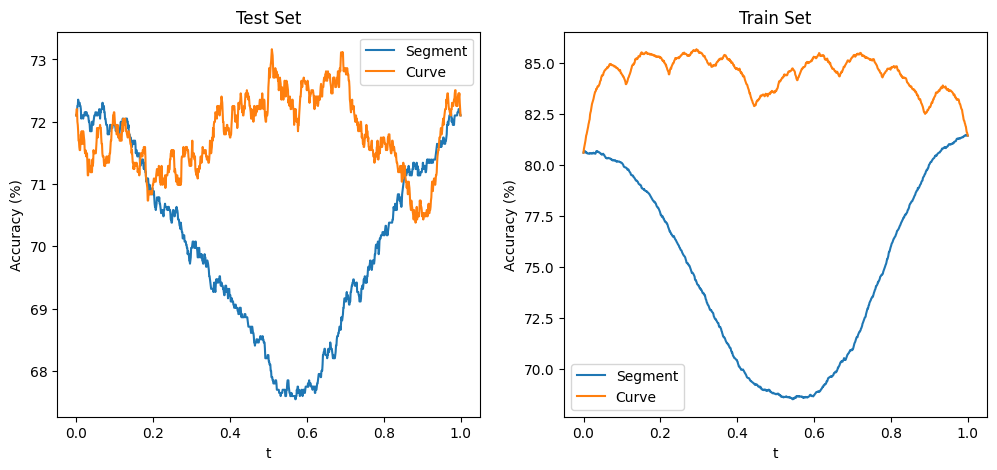

In [66]:
# Plot both plots below on one row, two columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
accs = [accuracies, accuracies_tr]
c_accs = [curve_accs, curve_accs_tr]
labs = ['Test Set', 'Train Set']

for i in range(2):
    ax[i].plot(ts, 100*np.array(accs[i]), label='Segment')
    ax[i].plot(ts, 100*np.array(c_accs[i]), label='Curve')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_title(labs[i])
    ax[i].legend()
plt.show()

# Analyse Curve

In [12]:
def get_model_from_curve(curve, t):
    # Get the state_dict at t
    state_dict_values = curve.get_weights(t=t)
    state_dict = torch.load(f'{directory}/{random_source}_model_{0}.pth')
    for i, key in enumerate(state_dict.keys()):
        state_dict[key] = state_dict_values[i]
    # Create the model
    m = model_class(*model_args)
    m.load_state_dict(state_dict)
    return m

In [67]:
# For each point on the curve, compute accuracies
ts = np.linspace(0.0, 1.0, 101)
curve_grads2 = np.zeros((len(ts), *X_test.shape))
for i, t in enumerate(tqdm(ts)):
    model = get_model_from_curve(curve=p_curve2, t=t)
    curve_grads2[i] = model.compute_gradients(X_test, return_numpy=True)

100%|██████████| 101/101 [00:00<00:00, 407.49it/s]


In [18]:
from style import plot_single_grad

In [68]:
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa
topk2 = []
for i, t in enumerate(ts):
    topk2.append(get_top_k(5, curve_grads2[i]))
topk2 = np.array(topk2)

In [69]:
from similarity_metrics import top_k_consistency
topk2[0,0], topk2[-1,0]

(array([ 3,  0,  4, 14, 12]), array([ 0,  9,  3, 14, 10]))

In [32]:
# Load and average gradients across all models
grads = np.zeros((n_models, *X_test.shape))
for i in range(n_models):
    grads[i] = np.load(f'{directory}/{random_source}_grads_{i}.npy')
grads = grads.mean(0)

In [44]:
tk_gt, s_gt = get_top_k(5, grads, return_sign=True)

In [70]:
tk_curve2, s_curve2 = get_top_k(5, curve_grads2.mean(axis=0), return_sign=True)

In [75]:
top_k_sa(tk_gt, tk_curve2, s_gt, s_curve2)

array([0.8, 0.4, 1. , ..., 0.8, 0.4, 0.8])

In [81]:
np.quantile(top_k_sa(tk_curve, tk_curve2, s_curve, s_curve2), [0.25, 0.5, 0.75])

array([0.6, 0.6, 0.8])